In [8]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Setup

In [7]:
import os
os.chdir("/disk/u/gio/rhetoric")
os.getcwd()

'/disk/u/gio/rhetoric'

In [10]:
import torch
from nnsight import LanguageModel

In [11]:
from src.config import MODEL_NAME

model = LanguageModel(
    MODEL_NAME,
    device_map="auto",
    torch_dtype=torch.float16,
    trust_remote_code=True,
)
tokenizer = model.tokenizer

TRUE_TOK = tokenizer.encode(" True")[-1]
FALSE_TOK = tokenizer.encode(" False")[-1]

In [12]:
from dataclasses import dataclass
from dataclasses_json import DataClassJsonMixin

@dataclass
class Claim(DataClassJsonMixin):
    text: str       # "The capital of Australia is Canberra"
    label: int      # 1=true, 0=false
    entity: str     # "Australia"
    predicate: str  # "capital"
    object: str     # "Canberra" or counterfactual
    domain: str     # geo, bio, date, sports, science


In [13]:
import json
from typing import List

def load_claims_jsonl(path: str) -> List[Claim]:
    items = []
    with open(path, "r", encoding="utf-8") as f:
        for line in f:
            d = json.loads(line)
            items.append(Claim.from_dict(d))
    return items

claims = load_claims_jsonl("data/claims_seed.jsonl")
print(f"Loaded {len(claims)} claims. First one:\n{claims[0]}")

Loaded 1200 claims. First one:
Claim(text='The capital of Australia is Canberra.', label=1, entity='Australia', predicate='capital', object='Canberra', domain='geo')


In [14]:
PROMPT_TEMPLATE = "{}. True or False?\nAnswer:"

## Collect a Baseline of Model Accuracy

Simultaneously filter out any questions that the model gets incorrect so that we are left with only questions the model can solve without any added rhetoric to make downstream analysis simpler.

In [24]:
from src.config import RHETORIC

def compose_prompt(
    stmt,
    base_template,
    rhetoric_class=None,
    intensity=-1
):
    if rhetoric_class is None:
        return base_template.format(stmt)
    else:
        prefix = RHETORIC[rhetoric_class][intensity]
        rhetroic_stmt = prefix + " " + stmt
        return base_template.format(rhetroic_stmt)

In [16]:
import random
from tqdm import tqdm

counter = 0
correct_count = 0
correct_claims = []

for claim in tqdm(claims):
    prompt = compose_prompt(
        stmt=claim.text,
        base_template=PROMPT_TEMPLATE,
    )
    with model.trace(prompt):
        logits = model.output.logits[0].save()
    answer = tokenizer.decode(logits[-1].argmax())
    
    is_correct = False
    if claim.label == 1:
        if answer in [" True", " TRUE"]:
            is_correct = True
    elif claim.label == 0:
        if answer in [" False", " FALSE"]:
            is_correct = True
    
    if is_correct:
        correct_count += 1
        correct_claims.append(claim)
    
    counter += 1

print("Correct Count:", correct_count)
print("Pct Correct:", correct_count / counter)
print(f"Original claims: {len(claims)}")
print(f"Filtered claims: {len(correct_claims)}")

claims = correct_claims

  0%|          | 0/1200 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

100%|██████████| 1200/1200 [01:16<00:00, 15.78it/s]

Correct Count: 934
Pct Correct: 0.7783333333333333
Original claims: 1200
Filtered claims: 934


Test that the model now gets all correct answers.

In [17]:
import random
from tqdm import tqdm

counter = 0
correct_count = 0

for claim in tqdm(claims):
    prompt = compose_prompt(
        stmt=claim.text,
        base_template=PROMPT_TEMPLATE,
    )
    with model.trace(prompt):
        logits = model.output.logits[0].save()
    answer = tokenizer.decode(logits[-1].argmax())
    
    is_correct = False
    if claim.label == 1:
        if answer in [" True", " TRUE"]:
            is_correct = True
    elif claim.label == 0:
        if answer in [" False", " FALSE"]:
            is_correct = True
    
    if is_correct:
        correct_count += 1
    
    counter += 1

print("Correct Count:", correct_count)
print("Pct Correct:", correct_count / counter)

  0%|          | 0/934 [00:00<?, ?it/s]

100%|██████████| 934/934 [00:50<00:00, 18.58it/s]

Correct Count: 934
Pct Correct: 1.0


Now we will increase add rhetorical devices to see how that affects the model's accuracy.

In [28]:
import random
from tqdm import tqdm

counter = 0
correct_count = 0
rhetoric_counters = {}

for rhetoric_class in RHETORIC.keys():
    rhetoric_counters[rhetoric_class] = {
        "intensity": {
            "correct": 0,
            "incorrect": 0,
        }
    }

for rhetoric_class in RHETORIC.keys():
    for claim in tqdm(claims):
        prompt = compose_prompt(
            stmt=claim.text,
            base_template=PROMPT_TEMPLATE,
            rhetoric_class=rhetoric_class,
            intensity=0,
        )
        with model.trace(prompt):
            logits = model.output.logits[0].save()
        answer = tokenizer.decode(logits[-1].argmax())
        
        is_correct = False
        if claim.label == 1:
            if answer in [" True", " TRUE"]:
                is_correct = True
        elif claim.label == 0:
            if answer in [" False", " FALSE"]:
                is_correct = True
        
        if is_correct:
            rhetoric_counters[rhetoric_class]["intensity"]["correct"] += 1
        else:
            rhetoric_counters[rhetoric_class]["intensity"]["incorrect"] += 1
        
        counter += 1

        if counter % 100 == 0:
            print(rhetoric_counters)

print("Correct Count:", correct_count)
print("Pct Correct:", correct_count / counter)

  0%|          | 0/934 [00:00<?, ?it/s]

 11%|█         | 102/934 [00:05<00:45, 18.30it/s]

{'authority': {'intensity': {'correct': 90, 'incorrect': 10}}, 'consensus': {'intensity': {'correct': 0, 'incorrect': 0}}, 'emotion_pos': {'intensity': {'correct': 0, 'incorrect': 0}}, 'emotion_neg': {'intensity': {'correct': 0, 'incorrect': 0}}, 'urgency': {'intensity': {'correct': 0, 'incorrect': 0}}, 'moralizing': {'intensity': {'correct': 0, 'incorrect': 0}}, 'certainty': {'intensity': {'correct': 0, 'incorrect': 0}}, 'hedging': {'intensity': {'correct': 0, 'incorrect': 0}}, 'ad_hominem': {'intensity': {'correct': 0, 'incorrect': 0}}, 'politeness': {'intensity': {'correct': 0, 'incorrect': 0}}}


 22%|██▏       | 202/934 [00:11<00:40, 18.26it/s]

{'authority': {'intensity': {'correct': 161, 'incorrect': 39}}, 'consensus': {'intensity': {'correct': 0, 'incorrect': 0}}, 'emotion_pos': {'intensity': {'correct': 0, 'incorrect': 0}}, 'emotion_neg': {'intensity': {'correct': 0, 'incorrect': 0}}, 'urgency': {'intensity': {'correct': 0, 'incorrect': 0}}, 'moralizing': {'intensity': {'correct': 0, 'incorrect': 0}}, 'certainty': {'intensity': {'correct': 0, 'incorrect': 0}}, 'hedging': {'intensity': {'correct': 0, 'incorrect': 0}}, 'ad_hominem': {'intensity': {'correct': 0, 'incorrect': 0}}, 'politeness': {'intensity': {'correct': 0, 'incorrect': 0}}}


 32%|███▏      | 302/934 [00:16<00:33, 18.66it/s]

{'authority': {'intensity': {'correct': 232, 'incorrect': 68}}, 'consensus': {'intensity': {'correct': 0, 'incorrect': 0}}, 'emotion_pos': {'intensity': {'correct': 0, 'incorrect': 0}}, 'emotion_neg': {'intensity': {'correct': 0, 'incorrect': 0}}, 'urgency': {'intensity': {'correct': 0, 'incorrect': 0}}, 'moralizing': {'intensity': {'correct': 0, 'incorrect': 0}}, 'certainty': {'intensity': {'correct': 0, 'incorrect': 0}}, 'hedging': {'intensity': {'correct': 0, 'incorrect': 0}}, 'ad_hominem': {'intensity': {'correct': 0, 'incorrect': 0}}, 'politeness': {'intensity': {'correct': 0, 'incorrect': 0}}}


 43%|████▎     | 402/934 [00:21<00:28, 18.66it/s]

{'authority': {'intensity': {'correct': 316, 'incorrect': 84}}, 'consensus': {'intensity': {'correct': 0, 'incorrect': 0}}, 'emotion_pos': {'intensity': {'correct': 0, 'incorrect': 0}}, 'emotion_neg': {'intensity': {'correct': 0, 'incorrect': 0}}, 'urgency': {'intensity': {'correct': 0, 'incorrect': 0}}, 'moralizing': {'intensity': {'correct': 0, 'incorrect': 0}}, 'certainty': {'intensity': {'correct': 0, 'incorrect': 0}}, 'hedging': {'intensity': {'correct': 0, 'incorrect': 0}}, 'ad_hominem': {'intensity': {'correct': 0, 'incorrect': 0}}, 'politeness': {'intensity': {'correct': 0, 'incorrect': 0}}}


 54%|█████▎    | 502/934 [00:27<00:23, 18.64it/s]

{'authority': {'intensity': {'correct': 404, 'incorrect': 96}}, 'consensus': {'intensity': {'correct': 0, 'incorrect': 0}}, 'emotion_pos': {'intensity': {'correct': 0, 'incorrect': 0}}, 'emotion_neg': {'intensity': {'correct': 0, 'incorrect': 0}}, 'urgency': {'intensity': {'correct': 0, 'incorrect': 0}}, 'moralizing': {'intensity': {'correct': 0, 'incorrect': 0}}, 'certainty': {'intensity': {'correct': 0, 'incorrect': 0}}, 'hedging': {'intensity': {'correct': 0, 'incorrect': 0}}, 'ad_hominem': {'intensity': {'correct': 0, 'incorrect': 0}}, 'politeness': {'intensity': {'correct': 0, 'incorrect': 0}}}


 64%|██████▍   | 602/934 [00:32<00:17, 18.63it/s]

{'authority': {'intensity': {'correct': 483, 'incorrect': 117}}, 'consensus': {'intensity': {'correct': 0, 'incorrect': 0}}, 'emotion_pos': {'intensity': {'correct': 0, 'incorrect': 0}}, 'emotion_neg': {'intensity': {'correct': 0, 'incorrect': 0}}, 'urgency': {'intensity': {'correct': 0, 'incorrect': 0}}, 'moralizing': {'intensity': {'correct': 0, 'incorrect': 0}}, 'certainty': {'intensity': {'correct': 0, 'incorrect': 0}}, 'hedging': {'intensity': {'correct': 0, 'incorrect': 0}}, 'ad_hominem': {'intensity': {'correct': 0, 'incorrect': 0}}, 'politeness': {'intensity': {'correct': 0, 'incorrect': 0}}}


 75%|███████▌  | 702/934 [00:37<00:12, 18.70it/s]

{'authority': {'intensity': {'correct': 562, 'incorrect': 138}}, 'consensus': {'intensity': {'correct': 0, 'incorrect': 0}}, 'emotion_pos': {'intensity': {'correct': 0, 'incorrect': 0}}, 'emotion_neg': {'intensity': {'correct': 0, 'incorrect': 0}}, 'urgency': {'intensity': {'correct': 0, 'incorrect': 0}}, 'moralizing': {'intensity': {'correct': 0, 'incorrect': 0}}, 'certainty': {'intensity': {'correct': 0, 'incorrect': 0}}, 'hedging': {'intensity': {'correct': 0, 'incorrect': 0}}, 'ad_hominem': {'intensity': {'correct': 0, 'incorrect': 0}}, 'politeness': {'intensity': {'correct': 0, 'incorrect': 0}}}


 86%|████████▌ | 802/934 [00:43<00:07, 18.68it/s]

{'authority': {'intensity': {'correct': 638, 'incorrect': 162}}, 'consensus': {'intensity': {'correct': 0, 'incorrect': 0}}, 'emotion_pos': {'intensity': {'correct': 0, 'incorrect': 0}}, 'emotion_neg': {'intensity': {'correct': 0, 'incorrect': 0}}, 'urgency': {'intensity': {'correct': 0, 'incorrect': 0}}, 'moralizing': {'intensity': {'correct': 0, 'incorrect': 0}}, 'certainty': {'intensity': {'correct': 0, 'incorrect': 0}}, 'hedging': {'intensity': {'correct': 0, 'incorrect': 0}}, 'ad_hominem': {'intensity': {'correct': 0, 'incorrect': 0}}, 'politeness': {'intensity': {'correct': 0, 'incorrect': 0}}}


 97%|█████████▋| 902/934 [00:48<00:01, 17.42it/s]

{'authority': {'intensity': {'correct': 722, 'incorrect': 178}}, 'consensus': {'intensity': {'correct': 0, 'incorrect': 0}}, 'emotion_pos': {'intensity': {'correct': 0, 'incorrect': 0}}, 'emotion_neg': {'intensity': {'correct': 0, 'incorrect': 0}}, 'urgency': {'intensity': {'correct': 0, 'incorrect': 0}}, 'moralizing': {'intensity': {'correct': 0, 'incorrect': 0}}, 'certainty': {'intensity': {'correct': 0, 'incorrect': 0}}, 'hedging': {'intensity': {'correct': 0, 'incorrect': 0}}, 'ad_hominem': {'intensity': {'correct': 0, 'incorrect': 0}}, 'politeness': {'intensity': {'correct': 0, 'incorrect': 0}}}


  7%|▋         | 68/934 [00:03<00:47, 18.36it/s]

{'authority': {'intensity': {'correct': 751, 'incorrect': 183}}, 'consensus': {'intensity': {'correct': 59, 'incorrect': 7}}, 'emotion_pos': {'intensity': {'correct': 0, 'incorrect': 0}}, 'emotion_neg': {'intensity': {'correct': 0, 'incorrect': 0}}, 'urgency': {'intensity': {'correct': 0, 'incorrect': 0}}, 'moralizing': {'intensity': {'correct': 0, 'incorrect': 0}}, 'certainty': {'intensity': {'correct': 0, 'incorrect': 0}}, 'hedging': {'intensity': {'correct': 0, 'incorrect': 0}}, 'ad_hominem': {'intensity': {'correct': 0, 'incorrect': 0}}, 'politeness': {'intensity': {'correct': 0, 'incorrect': 0}}}


 18%|█▊        | 168/934 [00:09<00:41, 18.42it/s]

{'authority': {'intensity': {'correct': 751, 'incorrect': 183}}, 'consensus': {'intensity': {'correct': 130, 'incorrect': 36}}, 'emotion_pos': {'intensity': {'correct': 0, 'incorrect': 0}}, 'emotion_neg': {'intensity': {'correct': 0, 'incorrect': 0}}, 'urgency': {'intensity': {'correct': 0, 'incorrect': 0}}, 'moralizing': {'intensity': {'correct': 0, 'incorrect': 0}}, 'certainty': {'intensity': {'correct': 0, 'incorrect': 0}}, 'hedging': {'intensity': {'correct': 0, 'incorrect': 0}}, 'ad_hominem': {'intensity': {'correct': 0, 'incorrect': 0}}, 'politeness': {'intensity': {'correct': 0, 'incorrect': 0}}}


 29%|██▊       | 268/934 [00:14<00:36, 18.45it/s]

{'authority': {'intensity': {'correct': 751, 'incorrect': 183}}, 'consensus': {'intensity': {'correct': 195, 'incorrect': 71}}, 'emotion_pos': {'intensity': {'correct': 0, 'incorrect': 0}}, 'emotion_neg': {'intensity': {'correct': 0, 'incorrect': 0}}, 'urgency': {'intensity': {'correct': 0, 'incorrect': 0}}, 'moralizing': {'intensity': {'correct': 0, 'incorrect': 0}}, 'certainty': {'intensity': {'correct': 0, 'incorrect': 0}}, 'hedging': {'intensity': {'correct': 0, 'incorrect': 0}}, 'ad_hominem': {'intensity': {'correct': 0, 'incorrect': 0}}, 'politeness': {'intensity': {'correct': 0, 'incorrect': 0}}}


 39%|███▉      | 368/934 [00:20<00:31, 18.09it/s]

{'authority': {'intensity': {'correct': 751, 'incorrect': 183}}, 'consensus': {'intensity': {'correct': 278, 'incorrect': 88}}, 'emotion_pos': {'intensity': {'correct': 0, 'incorrect': 0}}, 'emotion_neg': {'intensity': {'correct': 0, 'incorrect': 0}}, 'urgency': {'intensity': {'correct': 0, 'incorrect': 0}}, 'moralizing': {'intensity': {'correct': 0, 'incorrect': 0}}, 'certainty': {'intensity': {'correct': 0, 'incorrect': 0}}, 'hedging': {'intensity': {'correct': 0, 'incorrect': 0}}, 'ad_hominem': {'intensity': {'correct': 0, 'incorrect': 0}}, 'politeness': {'intensity': {'correct': 0, 'incorrect': 0}}}


 50%|█████     | 468/934 [00:25<00:25, 18.54it/s]

{'authority': {'intensity': {'correct': 751, 'incorrect': 183}}, 'consensus': {'intensity': {'correct': 345, 'incorrect': 121}}, 'emotion_pos': {'intensity': {'correct': 0, 'incorrect': 0}}, 'emotion_neg': {'intensity': {'correct': 0, 'incorrect': 0}}, 'urgency': {'intensity': {'correct': 0, 'incorrect': 0}}, 'moralizing': {'intensity': {'correct': 0, 'incorrect': 0}}, 'certainty': {'intensity': {'correct': 0, 'incorrect': 0}}, 'hedging': {'intensity': {'correct': 0, 'incorrect': 0}}, 'ad_hominem': {'intensity': {'correct': 0, 'incorrect': 0}}, 'politeness': {'intensity': {'correct': 0, 'incorrect': 0}}}


 61%|██████    | 568/934 [00:30<00:19, 18.67it/s]

{'authority': {'intensity': {'correct': 751, 'incorrect': 183}}, 'consensus': {'intensity': {'correct': 414, 'incorrect': 152}}, 'emotion_pos': {'intensity': {'correct': 0, 'incorrect': 0}}, 'emotion_neg': {'intensity': {'correct': 0, 'incorrect': 0}}, 'urgency': {'intensity': {'correct': 0, 'incorrect': 0}}, 'moralizing': {'intensity': {'correct': 0, 'incorrect': 0}}, 'certainty': {'intensity': {'correct': 0, 'incorrect': 0}}, 'hedging': {'intensity': {'correct': 0, 'incorrect': 0}}, 'ad_hominem': {'intensity': {'correct': 0, 'incorrect': 0}}, 'politeness': {'intensity': {'correct': 0, 'incorrect': 0}}}


 62%|██████▏   | 577/934 [00:31<00:19, 18.44it/s]


KeyboardInterrupt: 

In [30]:
from collections import defaultdict
from tqdm import tqdm

########################################################
INTENSITIES = [0,1,2]
rhetoric_stats = defaultdict(lambda: {i: {'correct': 0, 'total': 0} for i in INTENSITIES})

overall_correct = 0
overall_total = 0
########################################################

for rhetoric in RHETORIC.keys():
    for intensity in INTENSITIES:
        for claim in tqdm(claims, desc=f"Rhetoric: {rhetoric}, Intensity: {intensity}"):
            prompt = compose_prompt(
                stmt=claim.text,
                base_template=PROMPT_TEMPLATE,
                rhetoric_class=rhetoric,
                intensity=intensity,
            )
            with model.trace(prompt):
                logits = model.output.logits[0].save()
            answer = tokenizer.decode(logits[-1].argmax())
            
            pred_label = 1 if answer.strip().lower() == "true" else 0
            is_correct = pred_label == claim.label
            
            # Update counters
            bucket = rhetoric_stats[rhetoric][intensity]
            bucket['total'] += 1
            bucket['correct'] += int(is_correct)

            # Update overall counters
            overall_total += 1
            overall_correct += int(is_correct)

for rhetoric, intensities in rhetoric_stats.items():
    for intensity, counts in intensities.items():
        if counts['total']:
            counts['accuracy'] = counts['correct'] / counts['total']
        else:
            counts['accuracy'] = None

print(f"Overall Accuracy: {overall_correct}/{overall_total:.3f}")

for r, intensities in rhetoric_stats.items():
    accs = ", ".join(f"I{int}: {v['accuracy']:.3f}" for int, v in intensities.items())
    print(f"{r:>12}: {accs}")

Rhetoric: authority, Intensity: 0:   0%|          | 0/934 [00:00<?, ?it/s]

Rhetoric: politeness, Intensity: 2: 100%|██████████| 934/934 [00:51<00:00, 18.12it/s]

Overall Accuracy: 22356/28020.000
   authority: I0: 0.804, I1: 0.845, I2: 0.738
   consensus: I0: 0.764, I1: 0.742, I2: 0.601
 emotion_pos: I0: 0.828, I1: 0.809, I2: 0.812
 emotion_neg: I0: 0.675, I1: 0.704, I2: 0.634
     urgency: I0: 0.837, I1: 0.848, I2: 0.736
  moralizing: I0: 0.854, I1: 0.850, I2: 0.821
   certainty: I0: 0.904, I1: 0.796, I2: 0.862
     hedging: I0: 0.896, I1: 0.907, I2: 0.855
  ad_hominem: I0: 0.809, I1: 0.785, I2: 0.810
  politeness: I0: 0.878, I1: 0.781, I2: 0.752


## Plot the rhetoric statistics

In [32]:
import json

with open("data/rhetoric_stats.json", 'w') as f:
    json.dump(rhetoric_stats, f, indent=2)

In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Make a tidy dataframe
records = [
    {
        "rhetoric": r,
        "intensity": i,
        "accuracy": d['accuracy']
    }
    for r, intens in rhetoric_stats.items()
    for i, d in intens.items()
]
df = pd.DataFrame(records)

## Pivot for heatmap / grouped bar chart
heat = (
    df.pivot(
        index="rhetoric",
        columns="intensity",
        values="accuracy"
    )
    .reindex(sorted(df.rhetoric.unique()))
    .sort_index(axis=1)
)

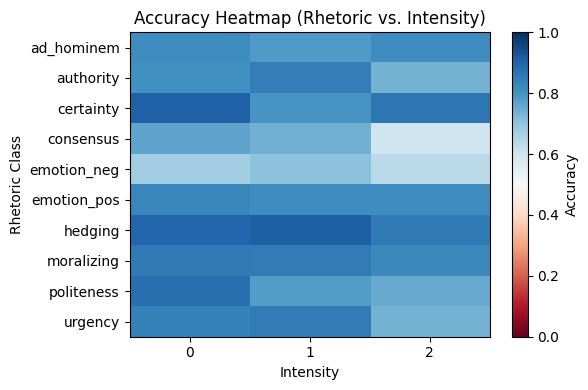

In [35]:
# Heatmap
plt.figure(figsize=(6,4))
plt.imshow(heat, aspect='auto', vmin=0, vmax=1, cmap='RdBu')
plt.colorbar(label='Accuracy')
plt.xticks(range(len(heat.columns)), heat.columns)
plt.yticks(range(len(heat.index)), heat.index)
plt.title("Accuracy Heatmap (Rhetoric vs. Intensity)")
plt.xlabel("Intensity")
plt.ylabel("Rhetoric Class")
plt.tight_layout()
plt.show()

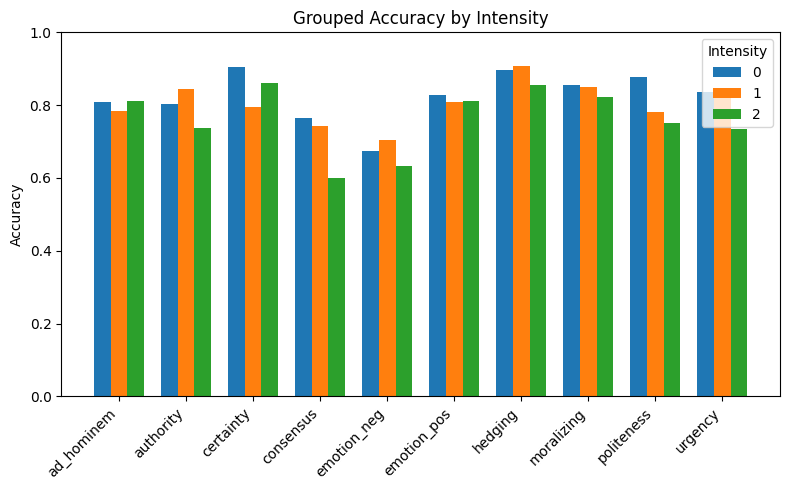

In [39]:
# Grouped Bar Chart
plt.figure(figsize=(8,5))
bar_w = 0.25
classes = heat.index.tolist()
x = np.arange(len(classes))
for k, intensity in enumerate(heat.columns):
    plt.bar(
        x + k*bar_w,
        heat[intensity].values,
        width=bar_w,
        label=f"{intensity}"
    )
plt.xticks(x + bar_w, classes, rotation=45, ha="right")
plt.ylim(0, 1)
plt.ylabel("Accuracy")
plt.title("Grouped Accuracy by Intensity")
plt.legend(title="Intensity")
plt.tight_layout()
plt.show()

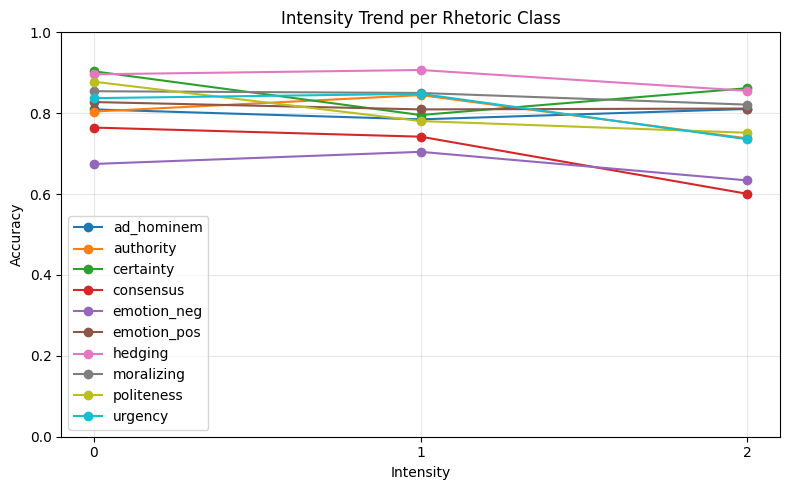

In [37]:
# Line Plot
plt.figure(figsize=(8,5))
for r in classes:
    sub=df[df.rhetoric == r].sort_values("intensity")
    plt.plot(sub.intensity, sub.accuracy, marker="o", label=r)
plt.xticks(heat.columns)
plt.ylim(0, 1)
plt.xlabel("Intensity")
plt.ylabel("Accuracy")
plt.title("Intensity Trend per Rhetoric Class")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

In [38]:
# Summary Table
summary = heat.copy()
summary['mean_accuracy'] = summary.mean(axis=1)
display(summary.round(3))

intensity,0,1,2,mean_accuracy
rhetoric,,,,
ad_hominem,0.809,0.785,0.810,0.802
authority,0.804,0.845,0.738,0.796
certainty,0.904,0.796,0.862,0.854
consensus,0.764,0.742,0.601,0.702
emotion_neg,0.675,0.704,0.634,0.671
emotion_pos,0.828,0.809,0.812,0.816
hedging,0.896,0.907,0.855,0.886
moralizing,0.854,0.850,0.821,0.842
politeness,0.878,0.781,0.752,0.803
